In [43]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [44]:
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_DIM = 64
NUM_LAYERS_SIMPLE = 1
NUM_LAYERS_DEEP = 5
NUM_EPOCHS = 50
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [45]:
df = pd.read_csv("data/SHEL_data.csv")


In [46]:
feature_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
values = df[feature_cols].astype(np.float32).values
n_samples, n_features = values.shape


In [47]:
split_idx = int(0.9 * n_samples)


In [48]:
scaler = StandardScaler()
values_train = values[:split_idx]
scaler.fit(values_train)
values_scaled = scaler.transform(values).astype(np.float32)


In [49]:
def make_sequences(values_scaled, seq_len, split_idx):
    X_train, y_train = [], []
    X_test, y_test = [], []

    ## training sequences: target index t in [seq_len, split_idx-1]
    for t in range(seq_len, split_idx):
        X_train.append(values_scaled[t-seq_len:t])
        y_train.append(values_scaled[t])

    ## test sequences: target index t in [split_idx, n_samples-1]
    n_total = values_scaled.shape[0]
    for t in range(split_idx, n_total):
        if t - seq_len < 0:
            continue
        X_test.append(values_scaled[t-seq_len:t])
        y_test.append(values_scaled[t])

    X_train = np.stack(X_train) ## [N_train, T, D]
    y_train = np.stack(y_train) ## [N_train, D]
    X_test = np.stack(X_test) ## [N_test, T, D]
    y_test = np.stack(y_test) ##[N_test, D]

    return X_train, y_train, X_test, y_test


In [50]:
X_train, y_train, X_test, y_test = make_sequences(values_scaled, SEQ_LEN, split_idx)


In [51]:
print("Train sequences:", X_train.shape, "Test sequences:", X_test.shape)


Train sequences: (849, 30, 6) Test sequences: (98, 30, 6)


In [52]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X) ## [N, T, D]
        self.y = torch.from_numpy(y) ## [N, D]

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [53]:
train_ds = TimeSeriesDataset(X_train, y_train)
test_ds = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [54]:
class TinyTimeMixerForecaster(nn.Module):
    """
    Tiny Time Mixer (TTM) architecture for time series forecasting.
    Based on IBM's Tiny Time Mixers model.
    """
    def __init__(self, input_dim, d_model, output_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        
        ## Input projection
        self.input_proj = nn.Linear(input_dim, d_model)
        
        ## Time Mixer layers
        self.mixer_layers = nn.ModuleList([
            TimeMixerLayer(d_model, dropout=dropout) 
            for _ in range(num_layers)
        ])
        
        ## Output projection
        self.output_proj = nn.Linear(d_model, output_dim)
        
    def forward(self, x):
        ## x: [B, T, D]
        x = self.input_proj(x) ## [B, T, d_model]
        
        ## Apply mixer layers
        for mixer in self.mixer_layers:
            x = mixer(x)
        
        ## Take the last time step
        x = x[:, -1, :] ## [B, d_model]
        
        ## Output projection
        pred = self.output_proj(x) ## [B, output_dim]
        return pred


class TimeMixerLayer(nn.Module):
    """
    Single Time Mixer layer with channel mixing and temporal mixing.
    Implements the core mixing operations of Tiny Time Mixers.
    """
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        
        ## Channel mixing (mixes across feature dimension)
        self.channel_mixer = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model),
            nn.Dropout(dropout)
        )
        
        ## Temporal mixing (mixes across time dimension)
        ## Applied per-feature across time steps
        self.temporal_mixer = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model),
            nn.Dropout(dropout)
        )
        
        ## Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
    def forward(self, x):
        ## x: [B, T, d_model]
        
        ## Channel mixing with residual connection
        ## Mixes information across the feature (d_model) dimension
        residual = x
        x = self.norm1(x)
        x = self.channel_mixer(x) ## [B, T, d_model]
        x = x + residual
        
        ## Temporal mixing with residual connection
        ## Mixes information across the temporal dimension
        residual = x
        x = self.norm2(x)
        ## The temporal mixer processes each time step independently
        ## but shares weights, enabling temporal pattern learning
        x = self.temporal_mixer(x) ## [B, T, d_model]
        x = x + residual
        
        return x


In [55]:
def make_model(model_name="Simple TTM"):
    if "Simple" in model_name:
        return TinyTimeMixerForecaster(
            n_features, HIDDEN_DIM, n_features,
            num_layers=NUM_LAYERS_SIMPLE
        )
    elif "Deep" in model_name:
        return TinyTimeMixerForecaster(
            n_features, HIDDEN_DIM, n_features,
            num_layers=NUM_LAYERS_DEEP
        )
    ## default
    return TinyTimeMixerForecaster(
        n_features, HIDDEN_DIM, n_features,
        num_layers=NUM_LAYERS_SIMPLE
    )


In [56]:
def train_model(model_name="Simple TTM"):
    model = make_model(model_name).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_ds)
        if epoch % 5 == 0 or epoch == 1:
            print(f"[{model_name}] Epoch {epoch}/{NUM_EPOCHS}, "
                  f"Train MSE (scaled): {train_loss:.4f}")

    return model


In [57]:
def compute_metrics(y_true_scaled, y_pred_scaled, X_test_scaled_last):
    """
    y_true_scaled: [N, D]
    y_pred_scaled: [N, D]
    X_test_scaled_last: [N, D]  (last input of each window, scaled)
    """
    ## Scaled RMSE
    mse_scaled = np.mean((y_pred_scaled - y_true_scaled) ** 2)
    rmse_scaled = np.sqrt(mse_scaled)

    ## MAPE (on original scale)
    y_true = scaler.inverse_transform(y_true_scaled)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    eps = 1e-6
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0

    ## Mean Directional Accuracy (direction of change from last input to target)
    ## use scaled values (sign preserved)
    last = X_test_scaled_last
    actual_change = np.sign(y_true_scaled - last)
    pred_change = np.sign(y_pred_scaled - last)
    correct_dir = (actual_change == pred_change).astype(np.float32)
    mda = correct_dir.mean()

    ## R^2 (on scaled)
    r2 = r2_score(
        y_true_scaled.reshape(-1),
        y_pred_scaled.reshape(-1)
    )

    ## Forecast bias (on original)
    bias_per_feature = np.mean(y_pred - y_true, axis=0)  # [D]
    bias_overall = bias_per_feature.mean()
    ## classify: over / under / none
    avg_abs_level = np.mean(np.abs(y_true))
    threshold = 0.01 * avg_abs_level ## 1% of average magnitude
    if abs(bias_overall) < threshold:
        bias_flag = "None / minimal"
    elif bias_overall > 0:
        bias_flag = "Over-forecast (too high)"
    else:
        bias_flag = "Under-forecast (too low)"

    metrics = {
        "Scaled_RMSE": float(rmse_scaled),
        "MAPE_percent": float(mape),
        "MDA": float(mda),
        "R2": float(r2),
        "Bias_overall": float(bias_overall),
        "Bias_flag": bias_flag,
        "Bias_per_feature": dict(zip(feature_cols, bias_per_feature))
    }
    return metrics


In [58]:

model_name = "Simple TTM"
model = train_model(model_name)


[Simple TTM] Epoch 1/50, Train MSE (scaled): 0.4245
[Simple TTM] Epoch 5/50, Train MSE (scaled): 0.1458
[Simple TTM] Epoch 10/50, Train MSE (scaled): 0.1426
[Simple TTM] Epoch 15/50, Train MSE (scaled): 0.1413
[Simple TTM] Epoch 20/50, Train MSE (scaled): 0.1383
[Simple TTM] Epoch 25/50, Train MSE (scaled): 0.1362
[Simple TTM] Epoch 30/50, Train MSE (scaled): 0.1347
[Simple TTM] Epoch 35/50, Train MSE (scaled): 0.1363
[Simple TTM] Epoch 40/50, Train MSE (scaled): 0.1374
[Simple TTM] Epoch 45/50, Train MSE (scaled): 0.1358
[Simple TTM] Epoch 50/50, Train MSE (scaled): 0.1350


In [59]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())


In [60]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)
y_true_scaled = np.concatenate(all_true_scaled, axis=0)
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)

In [61]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)



=== Metrics for Simple TTM ===
Scaled_RMSE : 0.41887354850769043
MAPE_percent : 6.278080463409424
MDA : 0.5850340127944946
R2 : 0.7953348159790039
Bias_overall : 30984.291015625
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 0.2285
  High: 0.2182
  Low: 0.3332
  Close: 0.3708
  Adj Close: -0.6529
  Volume: 185905.2500


In [62]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)



Row for spreadsheet: {'Model': 'Simple TTM', 'Scaled RMSE': 0.41887354850769043, 'MAPE': 6.278080463409424, 'Mean Directional Accuracy (MDA)': 0.5850340127944946, 'R^2': 0.7953348159790039, 'Forecast Bias?': 'Over-forecast (too high)'}


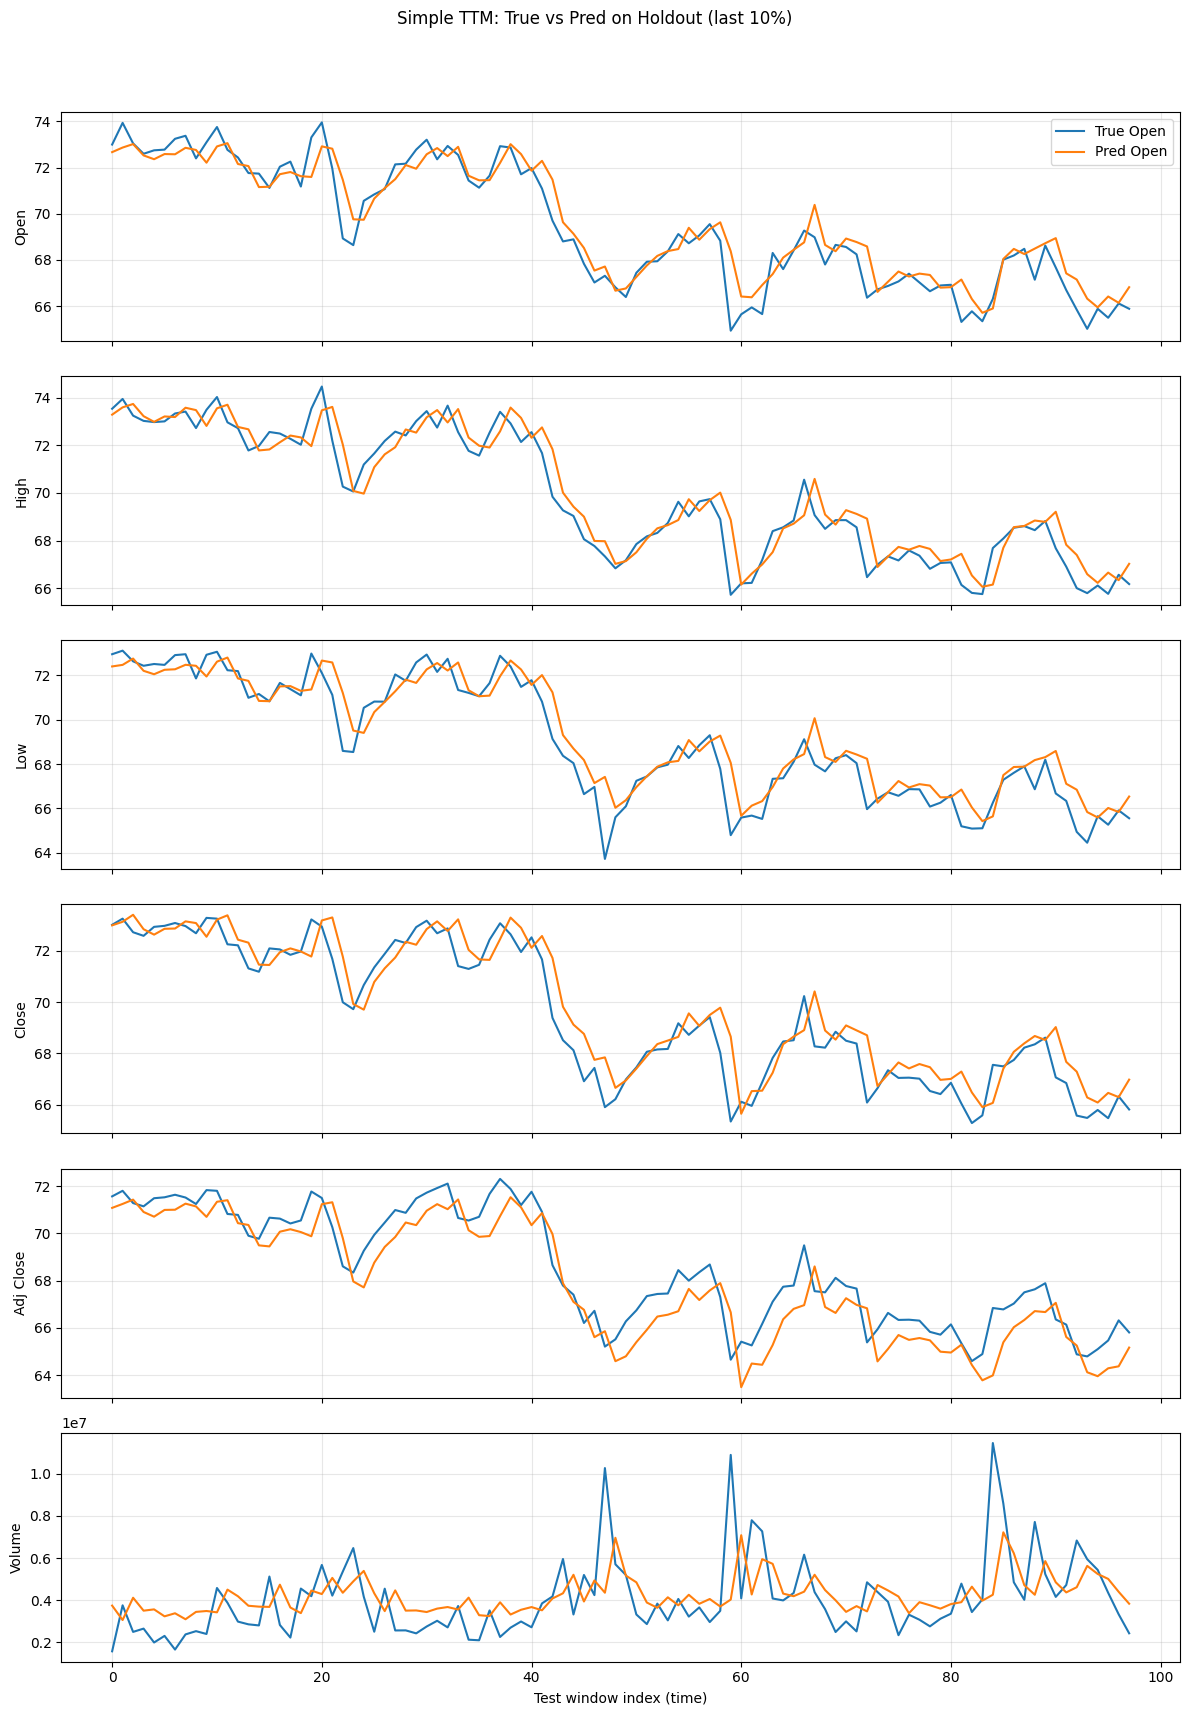

In [63]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**DEEP TINY TIME MIXER**


model_name = "Deep TTM"
model = train_model(model_name)


In [64]:
model_name = "Deep TTM"
model = train_model(model_name)


[Deep TTM] Epoch 1/50, Train MSE (scaled): 0.3596
[Deep TTM] Epoch 5/50, Train MSE (scaled): 0.1537
[Deep TTM] Epoch 10/50, Train MSE (scaled): 0.1504
[Deep TTM] Epoch 15/50, Train MSE (scaled): 0.1441
[Deep TTM] Epoch 20/50, Train MSE (scaled): 0.1462
[Deep TTM] Epoch 25/50, Train MSE (scaled): 0.1428
[Deep TTM] Epoch 30/50, Train MSE (scaled): 0.1398
[Deep TTM] Epoch 35/50, Train MSE (scaled): 0.1385
[Deep TTM] Epoch 40/50, Train MSE (scaled): 0.1375
[Deep TTM] Epoch 45/50, Train MSE (scaled): 0.1367
[Deep TTM] Epoch 50/50, Train MSE (scaled): 0.1389


In [65]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())


In [66]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)
y_true_scaled = np.concatenate(all_true_scaled, axis=0)
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)


In [67]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)



=== Metrics for Deep TTM ===
Scaled_RMSE : 0.4140965938568115
MAPE_percent : 6.184519290924072
MDA : 0.5765306353569031
R2 : 0.7999762892723083
Bias_overall : 30379.462890625
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 0.0589
  High: 0.1172
  Low: 0.2706
  Close: -0.1801
  Adj Close: 0.1714
  Volume: 182276.3438


In [68]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)



Row for spreadsheet: {'Model': 'Deep TTM', 'Scaled RMSE': 0.4140965938568115, 'MAPE': 6.184519290924072, 'Mean Directional Accuracy (MDA)': 0.5765306353569031, 'R^2': 0.7999762892723083, 'Forecast Bias?': 'Over-forecast (too high)'}


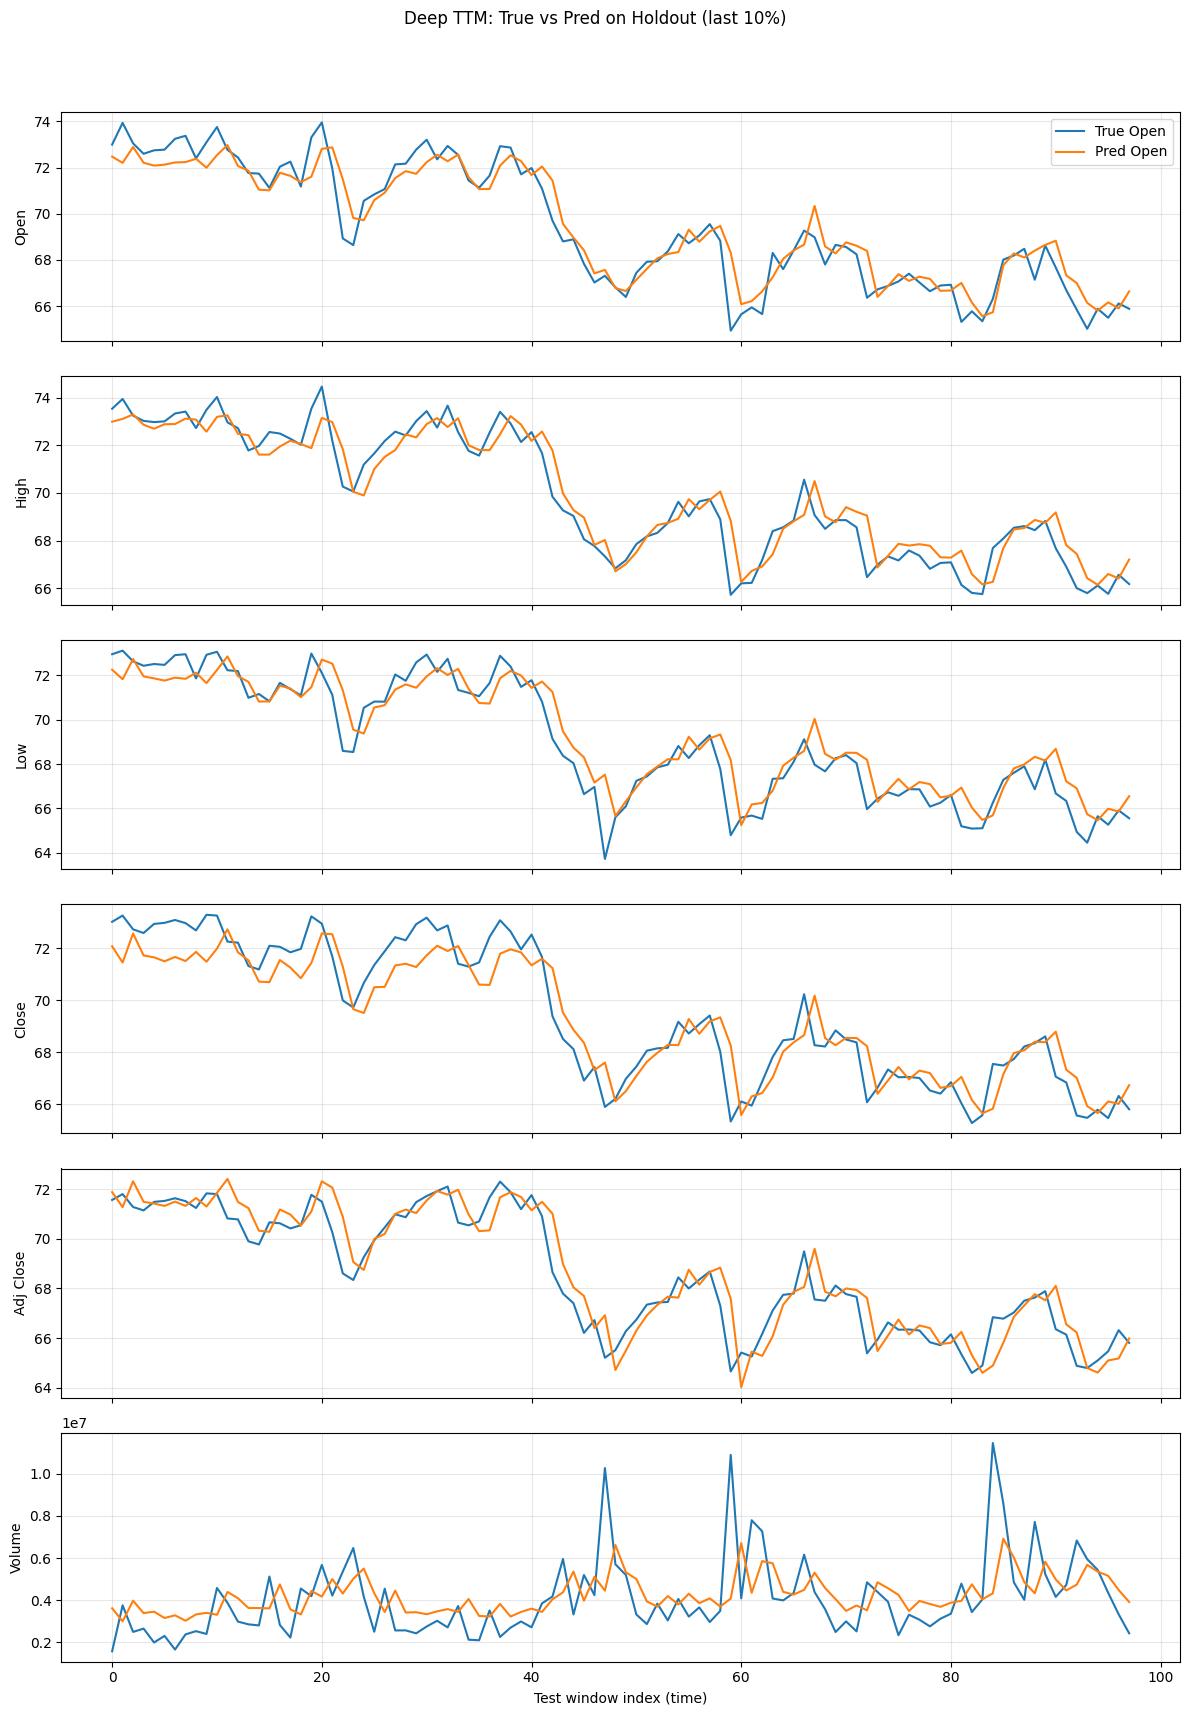

In [69]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
